Action: 资金流入流出预测    
https://tianchi.aliyun.com/competition/entrance/231573/information    
数据集一共包括4张表：用户基本信息数据、用户申购赎回数据、收益率表和银行间拆借利率表    
2.8万用户，284万行为数据，294天拆解利率，427天收益率    
2013-07-01到2014-08-31，预测2014年9月的申购和赎回

基于周期因子的时间序列预测。
- 对于周期性比较明显的时序数据可以使用此方法。
- base的计算方法和老师的略微不同
- 根据业务和假期情况，做了周期因子的微调。

In [1]:
import warnings
import datetime
import calendar

from chinese_calendar import is_holiday
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt


warnings.filterwarnings("ignore")

In [2]:
plt.rcParams["font.family"] = "SimHei"
plt.rcParams["axes.unicode_minus"] = False

# 加载数据

In [3]:
user_balance_df = pd.read_csv('user_balance_table.csv')

In [4]:
user_balance_df.head()

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,20140805,20385,20383,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
1,1,20140808,20391,20389,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
2,1,20140811,20397,20395,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
3,1,20140814,20403,20401,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
4,1,20140817,20409,20407,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN


In [5]:
# 除了4个category列，其他列无缺失值
user_balance_df.isna().sum()

user_id                      0
report_date                  0
tBalance                     0
yBalance                     0
total_purchase_amt           0
direct_purchase_amt          0
purchase_bal_amt             0
purchase_bank_amt            0
total_redeem_amt             0
consume_amt                  0
transfer_amt                 0
tftobal_amt                  0
tftocard_amt                 0
share_amt                    0
category1              2666682
category2              2666682
category3              2666682
category4              2666682
dtype: int64

# 数据预处理

In [6]:
def add_timestamp(df):
    """将日期列由数字解析为日期, 并生成年、月、日、周特征"""
    df['report_date'] = pd.to_datetime(df['report_date'], format="%Y%m%d")
    df['year'] = df['report_date'].dt.year
    df['month'] = df['report_date'].dt.month
    df['day'] = df['report_date'].dt.day
    df['week'] = df['report_date'].dt.week  # 一年中第几个星期
    df['weekday'] = df['report_date'].dt.weekday  # 0代表周1- 6代表周日
    return df


def get_total_balance(df, begin):
    """筛选指定日期之后的总购买量和总赎回量的DataFrame
    """
    df_temp = df.copy()
    # 按日期进行聚合
    df_temp = df_temp.groupby("report_date")['total_purchase_amt',
                                             'total_redeem_amt'].sum()
    df_temp = df_temp[df_temp.index >= begin]
    # 还原日期字段，重新索引
    df_temp = df_temp.reset_index()
    return df_temp


def generate_test_data(cols):
    """生成9月1日到30日测试集的数据集"""
    test = pd.DataFrame(np.full((30, 3), fill_value=np.nan, dtype=float),
                        columns=cols)
    test['report_date'] = pd.date_range('2014-09-01',
                                        '2014-09-30',
                                        freq='D',
                                        closed=None)  # 左右均闭

    return test.reset_index(drop=True)


def get_week_factor(df):
    """计算周期因子，返回DataFrame
    """
    cols = ["total_purchase_amt", "total_redeem_amt"]
    temp = df.copy()
    # 购买量和赎回量周一到周日每天的均值
    weekday_mean = temp.groupby('weekday')[cols].mean()
    # 购买量和赎回量的总均值数组
    total_mean_arr = temp[cols].mean().values
    # 周期因子
    weekday_mean[cols] /= total_mean_arr

    week_factor = weekday_mean.rename(columns={
        "total_purchase_amt": 'P_week_factor',
        'total_redeem_amt': 'R_week_factor'
    })
    return week_factor.reset_index()

In [7]:
temp = user_balance_df.copy()

In [8]:
user_balance_df = temp.copy()

## 筛选14年3月及之后的总购买量和总赎回量的DataFrame

In [9]:
user_balance_df = get_total_balance(user_balance_df, begin=20140301)
user_balance_df

,report_date,total_purchase_amt,total_redeem_amt
0,20140301,362865580,211279011
1,20140302,276202230,246199417
2,20140303,505305862,513017360
3,20140304,524146340,250562978
4,20140305,454295491,209072753
...,...,...,...
179,20140827,302194801,468164147
180,20140828,245082751,297893861
181,20140829,267554713,273756380
182,20140830,199708772,196374134


In [10]:
# 生成用于存储预测结果的DataFrame
test_df = generate_test_data(user_balance_df.columns)
test_df.head()

,report_date,total_purchase_amt,total_redeem_amt
0,2014-09-01,NaN,NaN
1,2014-09-02,NaN,NaN
2,2014-09-03,NaN,NaN
3,2014-09-04,NaN,NaN
4,2014-09-05,NaN,NaN


## 解析日期列并生成日期相关特征

In [11]:
user_balance_df = add_timestamp(user_balance_df)
user_balance_df.head()

,report_date,total_purchase_amt,total_redeem_amt,year,month,day,week,weekday
0,2014-03-01,362865580,211279011,2014,3,1,9,5
1,2014-03-02,276202230,246199417,2014,3,2,9,6
2,2014-03-03,505305862,513017360,2014,3,3,10,0
3,2014-03-04,524146340,250562978,2014,3,4,10,1
4,2014-03-05,454295491,209072753,2014,3,5,10,2


In [12]:
test_df = add_timestamp(test_df)

# 计算周期因子

In [13]:
week_factor_df = get_week_factor(user_balance_df)
week_factor_df

,weekday,P_week_factor,R_week_factor
0,0,1.185411,1.257964
1,1,1.209608,1.172248
2,2,1.163752,1.157944
3,3,1.139503,1.026762
4,4,0.902682,0.975445
5,5,0.709237,0.669791
6,6,0.712065,0.761712


In [14]:
# 将周期因子结果合并到user_balance_df中
user_balance_df = user_balance_df.merge(week_factor_df, on='weekday')

In [15]:
# 预测结果列中增加周期因子列
test_df = test_df.merge(week_factor_df, on='weekday', how='left')
test_df.shape

(30, 10)

# 计算日期因子

In [16]:
df = user_balance_df.copy()

In [17]:
df

,report_date,total_purchase_amt,total_redeem_amt,year,month,day,week,weekday,P_week_factor,R_week_factor
0,2014-03-01,362865580,211279011,2014,3,1,9,5,0.709237,0.669791
1,2014-03-08,243274169,140323202,2014,3,8,10,5,0.709237,0.669791
2,2014-03-15,287407002,242799048,2014,3,15,11,5,0.709237,0.669791
3,2014-03-22,191700135,138039412,2014,3,22,12,5,0.709237,0.669791
4,2014-03-29,160250985,155006056,2014,3,29,13,5,0.709237,0.669791
...,...,...,...,...,...,...,...,...,...,...
179,2014-08-01,374884735,252540858,2014,8,1,31,4,0.902682,0.975445
180,2014-08-08,233903717,311648757,2014,8,8,32,4,0.902682,0.975445
181,2014-08-15,244551620,236516007,2014,8,15,33,4,0.902682,0.975445
182,2014-08-22,246316056,179349206,2014,8,22,34,4,0.902682,0.975445


In [18]:
def get_date_factor(df):
    """计算日期因子"""
    df = df.copy()
    n_month = df['month'].nunique()
    df['weekday_freq'] = 0
    factor_cols = ['P_week_factor', 'R_week_factor']
    groupkey = ['day', 'weekday']
    groups = df.groupby(by=groupkey, as_index=False)
    # 统计所有1-31号中周一到周日出现的频次（比如：3月-9月里的1号中有几个周一、周二..周日）
    week_count = groups['weekday_freq'].count()
    # 会出现重复行，所以最后去重
    week_count = week_count.merge(df[groupkey + factor_cols], on=groupkey).drop_duplicates()
    # 日期因子=频次 * 周期因子 / 月数, 这里先计算 周期因子 / 月数
    week_count['P_day_factor'] = week_count['weekday_freq'].copy() / n_month
    week_count['R_day_factor'] = week_count['weekday_freq'].copy() / n_month
    week_count['P_day_factor'] *= week_count[factor_cols[0]]
    week_count['R_day_factor'] *= week_count[factor_cols[1]]
    # 求和后就得到每天的日期因子
    date_factor = week_count.groupby('day')[['P_day_factor', 'R_day_factor']].sum()
    del df['weekday_freq']
    return date_factor

In [19]:
date_factor = get_date_factor(df)
date_factor.head(2)

,P_day_factor,R_day_factor
day,,
1,0.980451,0.963034
2,0.972816,0.996800


In [20]:
date_factor.shape

(31, 2)

In [21]:
test_df = test_df.merge(date_factor.reset_index(), on='day', how='left')
test_df.shape

(30, 12)

# 计算base

In [22]:
# 课堂的base计算方法 每日均值/日期因子 得分最高是131+
# 分数不高，130+
def get_base1(df):
    cols = ["total_purchase_amt", "total_redeem_amt"]
    groupkey = ['weekday', 'day']
    # 按[周, 天]分组计算均值
    groups = df.groupby(by=groupkey)
    mean_by_week_and_day = groups[cols].mean()
    mean_by_week_and_day.columns = ['P_WDmean', 'R_WDmean']
    mean_by_week_and_day = mean_by_week_and_day.reset_index()   
    # 方法1：直接除以周期因子
    week_factor_df = get_week_factor(df)
    # 按周、天的每日均值和周期因子合并
    tmp = week_factor_df.merge(mean_by_week_and_day, on='weekday', how='right')
    tmp['P_base1'] = tmp['P_WDmean'] / tmp['P_week_factor']
    tmp['R_base1'] = tmp['R_WDmean'] / tmp['R_week_factor']
    # 去掉周期因子后的均值作为base
    tmp = tmp.groupby('day')['P_base1', 'R_base1'].mean()    
    return tmp.reset_index()


In [23]:
base1_df = get_base1(df)
base1_df.head()

,day,P_base1,R_base1
0,1,3.400634e+08,2.377181e+08
1,2,2.489438e+08,2.199764e+08
2,3,2.891372e+08,2.944385e+08
3,4,3.260983e+08,3.027272e+08
4,5,3.250445e+08,2.574470e+08


In [24]:
base1_df.shape

(31, 3)

In [25]:
test_df = test_df.merge(base1_df, on='day', how='left')
test_df.shape

(30, 14)

In [26]:
def get_base2(df):
    cols = ["total_purchase_amt", "total_redeem_amt"]
    groupkey = ['day']
    # 按天分组计算均值
    groups = df.groupby(by=groupkey)
    mean_by_week_and_day = groups[cols].mean()
    mean_by_week_and_day.columns = ['P_WDmean', 'R_WDmean']
    mean_by_week_and_day = mean_by_week_and_day.reset_index()   
    # 方法1：直接除以日期因子
    date_factor = get_date_factor(df)
    # 按周、天的每日均值和日期因子合并
    tmp = date_factor.merge(mean_by_week_and_day, on='day', how='right')
    tmp['P_base2'] = tmp['P_WDmean'] / tmp['P_day_factor']
    tmp['R_base2'] = tmp['R_WDmean'] / tmp['R_day_factor']  
    return tmp[['day', 'P_base2', 'R_base2']]

In [27]:
base2_df = get_base2(df)
base2_df.head(2)

,day,P_base2,R_base2
0,1,3.318261e+08,2.437791e+08
1,2,2.550589e+08,2.193092e+08


In [28]:
base2_df.shape

(31, 3)

# 预测

In [29]:
test_df = test_df.merge(base2_df, on='day', how='left').sort_values(by='report_date')
test_df.shape

(30, 16)

In [30]:
test_df.head()

,report_date,total_purchase_amt,total_redeem_amt,year,month,day,week,weekday,P_week_factor,R_week_factor,P_day_factor,R_day_factor,P_base1,R_base1,P_base2,R_base2
0,2014-09-01,NaN,NaN,2014,9,1,36,0,1.185411,1.257964,0.980451,0.963034,3.400634e+08,2.377181e+08,3.318261e+08,2.437791e+08
1,2014-09-02,NaN,NaN,2014,9,2,36,1,1.209608,1.172248,0.972816,0.996800,2.489438e+08,2.199764e+08,2.550589e+08,2.193092e+08
2,2014-09-03,NaN,NaN,2014,9,3,36,2,1.163752,1.157944,1.015888,0.985873,2.891372e+08,2.944385e+08,2.947971e+08,3.010781e+08
3,2014-09-04,NaN,NaN,2014,9,4,36,3,1.139503,1.026762,1.012700,1.050126,3.260983e+08,3.027272e+08,3.120176e+08,2.785948e+08
4,2014-09-05,NaN,NaN,2014,9,5,36,4,0.902682,0.975445,1.019458,0.992417,3.250445e+08,2.574470e+08,3.223549e+08,2.571989e+08


## 135.5091 使用base2进行预测

In [31]:
tmp_df = test_df.copy()

In [32]:
test_df = tmp_df.copy()

test_df['total_purchase_amt'] = test_df['P_base2'] * test_df['P_week_factor']
test_df['total_redeem_amt'] = test_df['R_base2'] * test_df['R_week_factor']

cols = ['total_purchase_amt', 'total_redeem_amt']
pred_df = test_df[['report_date'] + cols].copy()
pred_df.describe()

,total_purchase_amt,total_redeem_amt
count,3.000000e+01,3.000000e+01
mean,2.814917e+08,2.782241e+08
std,6.936285e+07,6.052093e+07
min,1.736759e+08,1.624970e+08
25%,2.193003e+08,2.495423e+08
50%,2.924079e+08,2.926650e+08
75%,3.378793e+08,3.196943e+08
max,3.947967e+08,3.674905e+08


In [33]:
pred_df[cols] = pred_df[cols].astype(int)

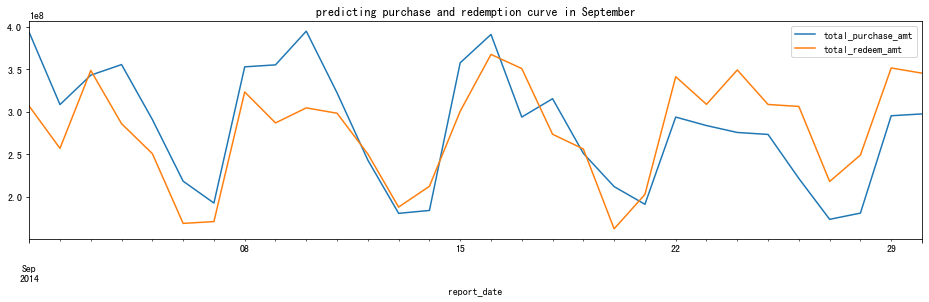

In [34]:
pred_df.set_index('report_date').plot(
    figsize=(16, 4),
    title="predicting purchase and redemption curve in September")

In [35]:
print(calendar.month(2014, 9))

   September 2014
Mo Tu We Th Fr Sa Su
 1  2  3  4  5  6  7
 8  9 10 11 12 13 14
15 16 17 18 19 20 21
22 23 24 25 26 27 28
29 30



### 135.5091 不根据假期调整日期，直接保存预测结果

In [36]:
# 修改日期列的格式
pred_df['report_date'] = pred_df['report_date'].dt.strftime("%Y%m%d")

In [37]:
pred_df.to_csv("tc_comp_predict_table_factor_135.5091.csv", header=None, index=False)

### 135.5091 尝试按照假期调整

In [38]:
# 日期微调
# 2014年9月6、7、8放假，28日上班
tmp = pred_df.copy()
# 8日是周一，但实际是假期，所以使用7日的数据代替
tmp.loc[tmp['report_date'] == 20140908,
        cols] = tmp.loc[tmp['report_date'] == 20140907, cols].values

# 28日是周日，但实际是上班，所以使用29日的数据代替
tmp.loc[tmp['report_date'] == '2014-09-28',
        cols] = tmp.loc[tmp['report_date'] == 20140929, cols].values

pred_df = tmp.copy()

# 2个日期都微调或者只微调8日 成绩仍然都135.5091
pred_df.to_csv("tc_comp_predict_table_factor_date8_135.5091.csv", header=None, index=False)

## 尝试调整周期因子的权重

In [39]:
user_balance_df = pd.read_csv('user_balance_table.csv')
user_balance_df = user_balance_df.groupby("report_date", as_index=False)[cols].sum()
user_balance_df = add_timestamp(user_balance_df)
user_balance_df.head(2)

,report_date,total_purchase_amt,total_redeem_amt,year,month,day,week,weekday
0,2013-07-01,32488348,5525022,2013,7,1,27,0
1,2013-07-02,29037390,2554548,2013,7,2,27,1


In [40]:
user_balance_df = user_balance_df.set_index('report_date')

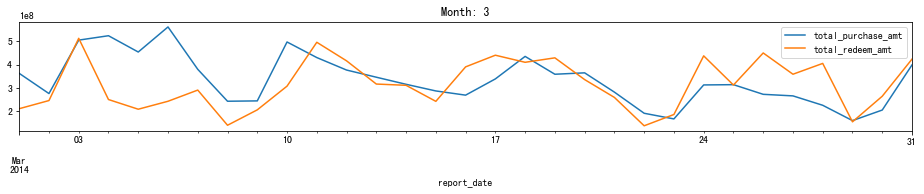

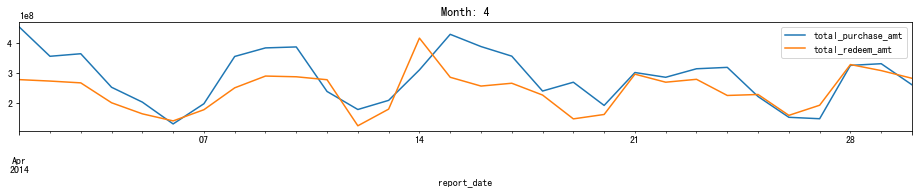

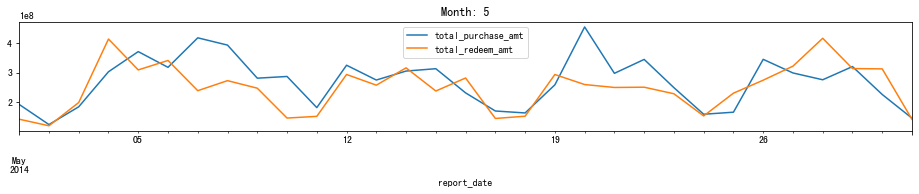

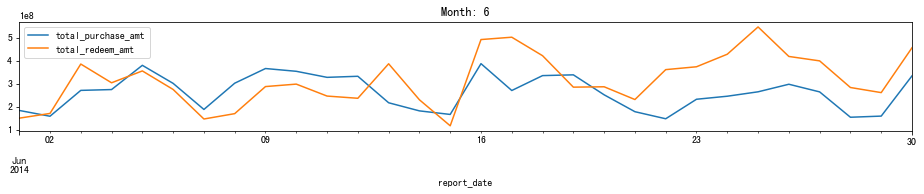

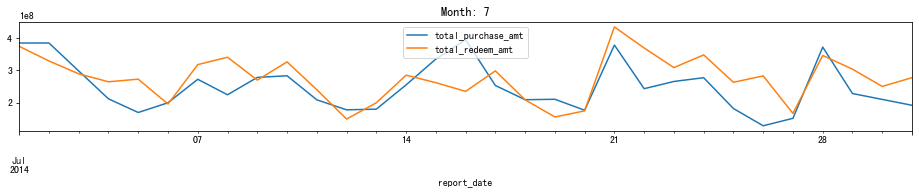

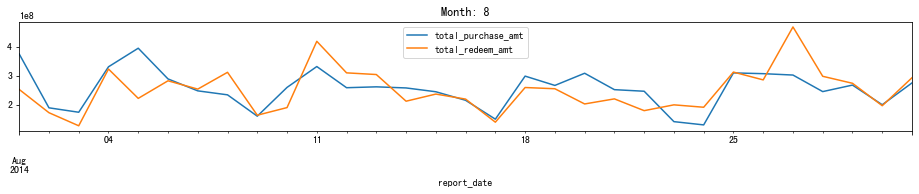

In [41]:
for i in range(3, 9):
    index = '2014-0%d' % i
    user_balance_df.loc[index, cols].plot(figsize=(16, 2), title="Month: %d" % i)

- 观察4月份曲线，每周末数据会处于低谷，且在周二、周三数据较高。判断每周是一个周期。数据抖动幅度较大。
- 每月有4个波峰和波谷。

In [42]:
print(calendar.month(2013, 9))

   September 2013
Mo Tu We Th Fr Sa Su
                   1
 2  3  4  5  6  7  8
 9 10 11 12 13 14 15
16 17 18 19 20 21 22
23 24 25 26 27 28 29
30



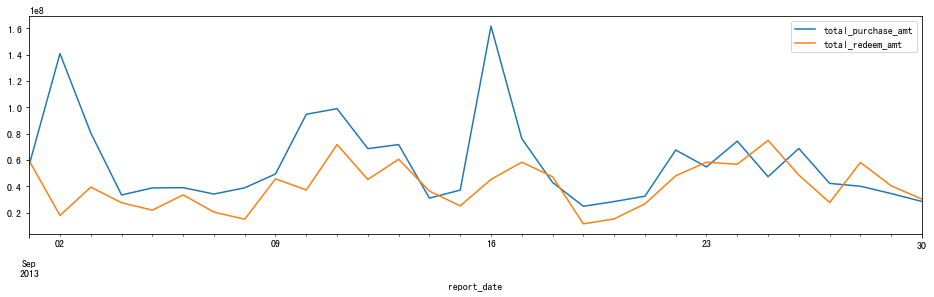

In [43]:
# 2013年19、20、21是中秋节假期，22，29上班
user_balance_df.loc['2013-09', cols].plot(figsize=(16, 4))

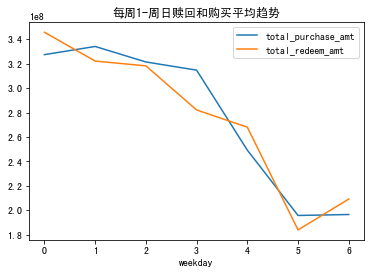

In [44]:
user_balance_df.loc["2014-03":].groupby('weekday')[cols].mean().plot(title="每周1-周日赎回和购买平均趋势")

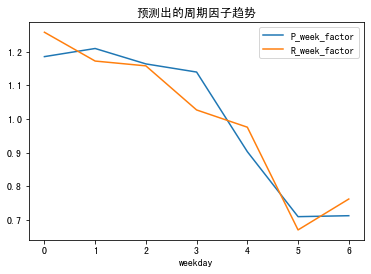

In [45]:
# 果然趋势和平均趋势是一模一样
week_factor_df.set_index('weekday')[['P_week_factor', 'R_week_factor']].plot(title="预测出的周期因子趋势")

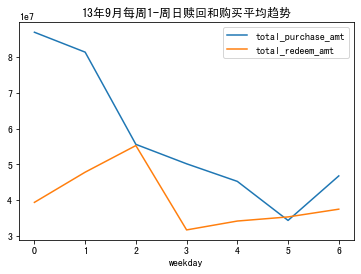

In [46]:
# 13年9月的数据
user_balance_df.loc["2013-09"].groupby('weekday')[cols].mean().plot(title="13年9月每周1-周日赎回和购买平均趋势")

### 140.4200 仅降低周日周期因子权重

每周末数据处于低谷，所以降低周日的周期因子

In [47]:
def adusted_predict(tmp_df, adjusted_weight):
    test_df = tmp_df.copy()
    adjusted = test_df.groupby('weekday',
                               as_index=False)['P_week_factor',
                                               'R_week_factor'].min()
    adjusted['adjusted_P_week_factor'] = adjusted_weight[
        'P_adusted_weight'] * adjusted['P_week_factor']
    adjusted['adjusted_R_week_factor'] = adjusted_weight[
        'R_adusted_weight'] * adjusted['R_week_factor']
    test_df = test_df.merge(
        adjusted.drop(columns=['P_week_factor', 'R_week_factor']),
        on='weekday',
        how='left')
    test_df['total_purchase_amt'] = test_df['P_base2'] * test_df[
        'adjusted_P_week_factor']
    test_df['total_redeem_amt'] = test_df['R_base2'] * test_df[
        'adjusted_R_week_factor']
    cols = ['total_purchase_amt', 'total_redeem_amt']
    pred_df = test_df[['report_date'] + cols].copy()
    # 修改日期列的格式
    pred_df['report_date'] = pred_df['report_date'].dt.strftime("%Y%m%d")

    # 保存预测结果
    pred_df.to_csv("tc_comp_predict_table_factor_adjusted.csv",
                   header=None,
                   index=False)

    pred_df.set_index('report_date').plot(
        figsize=(16, 4),
        title=
        "predicting purchase and redemption curve with adjusted weight in September"
    )

In [48]:
tmp_df = test_df.copy()

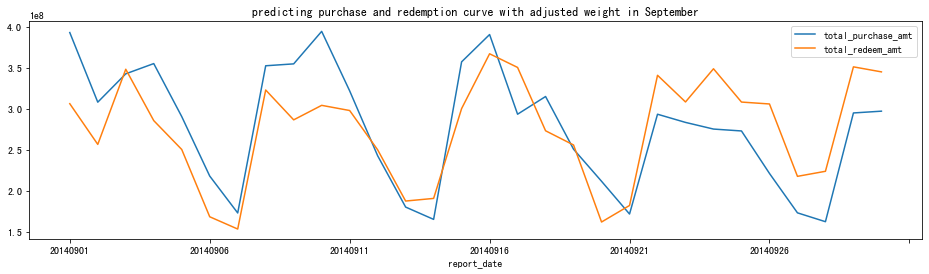

In [49]:
adjusted_weight = pd.DataFrame({
    "P_adusted_weight": [1, 1, 1, 1, 1, 1, 0.9],
    "R_adusted_weight": [1, 1, 1, 1, 1, 1, 0.9]
})

adusted_predict(tmp_df, adjusted_weight)

### 146.7478 调整权重后最佳分数

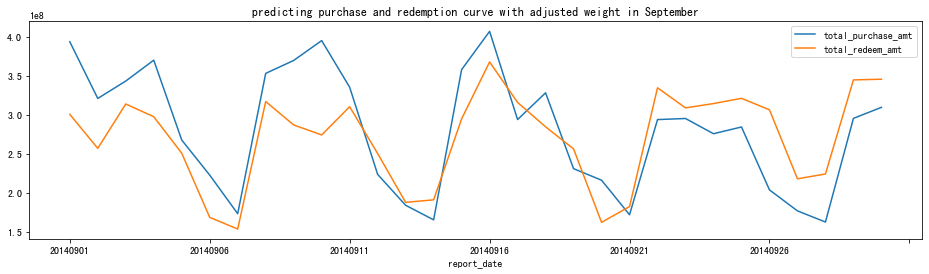

In [50]:
# 146.7478
adjusted_weight = pd.DataFrame({
    "P_adusted_weight": [1, 1.04, 1, 1.04, 0.92, 1.02, 0.9],
    "R_adusted_weight": [0.98, 1, 0.9, 1.04, 1, 1, 0.9]
})

adusted_predict(tmp_df, adjusted_weight)

- 从2014年的趋势曲线看，周三购买量和赎回量较高；但2013年的赎回较低。故尝试调整了周三的周期因子权重后，找到最佳权重
- 从2014各月购买量和赎回量曲线可知周日较低，所以降低周日周期因子权重；
- 由于训练集中周一存在2个假期，测试集(9月)有1个假期，调试周一的权重，找到最佳权重；
- 考虑周二是假期的第一个工作日，调试周二的权重，找到最佳权重；
- 考虑周五购买的话，周六日不确认没收益，大部分可能会选择提前购买，或者不购买，因此调试周五权重，找到最佳权重。
- 周六购买，周一确认，购买可能性高，增加购买量权重。

### 其他调权重后分数低于最佳分数的记录

In [51]:
# 141.4534
# adjusted_weight = pd.DataFrame({
#     "P_adusted_weight": [1, 1, 1, 1, 1, 1, 0.9],
#     "R_adusted_weight": [1, 1, 0.9, 1, 1, 1, 0.9]
# })

# 增加周三购买量周期因子权重，得分135.1859
# adjusted_weight = pd.DataFrame({
#     "P_adusted_weight": [1, 1, , 1, 1, 1, 0.9],
#     "R_adusted_weight": [1, 1, 0.9, 1, 1, 1, 0.9]
# })

# 根据2013年周六购买量低于赎回量降低权重，得分变差：133.5423
# adjusted_weight = pd.DataFrame({
#     "P_adusted_weight": [1, 1, 1.1, 1, 1, 1, 0.9],
#     "R_adusted_weight": [1, 1, 0.9, 1, 1, 1, 0.9]
# })

# 周五购买的话，周六日不确认，所以判断周五购买量会低，降低该天购买量的权重 得分142.6901
# adjusted_weight = pd.DataFrame({
#     "P_adusted_weight": [1, 1, 1, 1, 0.9, 1, 0.9],
#     "R_adusted_weight": [1, 1, 0.9, 1, 1, 1, 0.9]
# })
# adusted_predict(tmp_df, adjusted_weight)

In [52]:
# 139.8618 周日权重降低过大
# adjusted_weight = pd.DataFrame({
#     "P_adusted_weight": [1, 1, 1, 1, 0.9, 1, 0.8],
#     "R_adusted_weight": [1, 1, 0.9, 1, 1, 1, 0.8]
# })

# adusted_predict(tmp_df, adjusted_weight)

In [53]:
# 9月8日是周一，但实际是假期，而拟合的数据中有2个假期在周一，猜测实际周期因子会不会高一些 得分140.0596
# 2个因子一起修改
# adjusted_weight = pd.DataFrame({
#     "P_adusted_weight": [1.1, 1, 1, 1, 0.9, 1, 0.9],
#     "R_adusted_weight": [1.1, 1, 0.9, 1, 1, 1, 0.9]
# })
# 只提高购买量周期因子 141.6164
# adjusted_weight = pd.DataFrame({
#     "P_adusted_weight": [1.1, 1, 1, 1, 0.9, 1, 0.9],
#     "R_adusted_weight": [1., 1, 0.9, 1, 1, 1, 0.9]
# })
# adusted_predict(tmp_df, adjusted_weight)

In [54]:
# # 143.4733 假如购买量一起降低0.98，则得分下降142.5903 
# adjusted_weight = pd.DataFrame({
#     "P_adusted_weight": [1, 1, 1, 1, 0.9, 1, 0.9],
#     "R_adusted_weight": [0.98, 1, 0.9, 1, 1, 1, 0.9]
# })
# adusted_predict(tmp_df, adjusted_weight)

In [55]:
# # 143.6449 周二是挨着假期之后的第一个工作日，增加购买量周期因子的权重
# adjusted_weight = pd.DataFrame({
#     "P_adusted_weight": [1, 1.02, 1, 1, 0.9, 1, 0.9],
#     "R_adusted_weight": [0.98, 1, 0.9, 1, 1, 1, 0.9]
# })
# adusted_predict(tmp_df, adjusted_weight)

In [56]:
# 143.7381 
# adjusted_weight = pd.DataFrame({
#     "P_adusted_weight": [1, 1.04, 1, 1, 0.9, 1, 0.9],
#     "R_adusted_weight": [0.98, 1, 0.9, 1, 1, 1, 0.9]
# })
# adusted_predict(tmp_df, adjusted_weight)

# 142.5329 增加比例过大了 
# adjusted_weight = pd.DataFrame({
#     "P_adusted_weight": [1, 1.1, 1, 1, 0.9, 1, 0.9],
#     "R_adusted_weight": [0.98, 1, 0.9, 1, 1, 1, 0.9]
# })
# adusted_predict(tmp_df, adjusted_weight)

# 143.1258
# adjusted_weight = pd.DataFrame({
#     "P_adusted_weight": [1, 1.06, 1, 1, 0.9, 1, 0.9],
#     "R_adusted_weight": [0.98, 1, 0.9, 1, 1, 1, 0.9]
# })
# adusted_predict(tmp_df, adjusted_weight)

# 143.1448 
# adjusted_weight = pd.DataFrame({
#     "P_adusted_weight": [1, 1.04, 1, 1, 0.92, 1, 0.9],
#     "R_adusted_weight": [0.98, 1.01, 0.9, 1, 1, 1, 0.9]
# })
# adusted_predict(tmp_df, adjusted_weight)

In [57]:
# # 145.6815
# adjusted_weight = pd.DataFrame({
#     "P_adusted_weight": [1, 1.04, 1, 1.04, 0.92, 1, 0.9],
#     "R_adusted_weight": [0.98, 1, 0.9, 1, 1, 1, 0.9]
# })
# adusted_predict(tmp_df, adjusted_weight)

In [58]:
# # 145.3355 周四购买量的权重大了
# adjusted_weight = pd.DataFrame({
#     "P_adusted_weight": [1, 1.04, 1, 1.06, 0.92, 1, 0.9],
#     "R_adusted_weight": [0.98, 1, 0.9, 1, 1, 1, 0.9]
# })
# adusted_predict(tmp_df, adjusted_weight)

In [59]:
# # 145.1276 周四赎回量权重降低后分数降低了
# adjusted_weight = pd.DataFrame({
#     "P_adusted_weight": [1, 1.04, 1, 1.04, 0.92, 1, 0.9],
#     "R_adusted_weight": [0.98, 1, 0.9, 0.98, 1, 1, 0.9]
# })
# adusted_predict(tmp_df, adjusted_weight)

In [60]:
# # 145.9491 周四赎回量权重也增加
# adjusted_weight = pd.DataFrame({
#     "P_adusted_weight": [1, 1.04, 1, 1.04, 0.92, 1, 0.9],
#     "R_adusted_weight": [0.98, 1, 0.9, 1.01, 1, 1, 0.9]
# })
# adusted_predict(tmp_df, adjusted_weight)

In [61]:
# # 144.9352
# adjusted_weight = pd.DataFrame({
#     "P_adusted_weight": [1, 1.04, 1, 1.02, 0.92, 1, 0.9],
#     "R_adusted_weight": [0.98, 1, 0.9, 1, 1, 1, 0.9]
# })
# adusted_predict(tmp_df, adjusted_weight)

In [62]:
# # 146.5936 周四购买和赎回量权重增加
# adjusted_weight = pd.DataFrame({
#     "P_adusted_weight": [1, 1.04, 1, 1.04, 0.92, 1, 0.9],
#     "R_adusted_weight": [0.98, 1, 0.9, 1.04, 1, 1, 0.9]
# })
# adusted_predict(tmp_df, adjusted_weight)

In [63]:
# # 146.6578 
# adjusted_weight = pd.DataFrame({
#     "P_adusted_weight": [1, 1.04, 1, 1.04, 0.92, 1.01, 0.9],
#     "R_adusted_weight": [0.98, 1, 0.9, 1.04, 1, 1, 0.9]
# })

# adusted_predict(tmp_df, adjusted_weight)

In [64]:
# # 144.2175
# adjusted_weight = pd.DataFrame({
#     "P_adusted_weight": [1, 1.04, 1, 1, 0.92, 1, 0.9],
#     "R_adusted_weight": [0.98, 1, 0.9, 1, 1, 1, 0.9]
# })
# adusted_predict(tmp_df, adjusted_weight)

In [65]:
# # 146.7478
# adjusted_weight = pd.DataFrame({
#     "P_adusted_weight": [1, 1.04, 1, 1.04, 0.92, 1.02, 0.9],
#     "R_adusted_weight": [0.98, 1, 0.9, 1.04, 1, 1, 0.9]
# })

# adusted_predict(tmp_df, adjusted_weight)

In [66]:
# # 144.5667
# adjusted_weight = pd.DataFrame({
#     "P_adusted_weight": [1, 1.04, 1, 1.01, 0.92, 1, 0.9],
#     "R_adusted_weight": [0.98, 1, 0.9, 1, 1, 1, 0.9]
# })
# adusted_predict(tmp_df, adjusted_weight)